# BIAS - Nico Keeghan

We start by importing all the libraries we are interested in.

In [2]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import gc                                 # What does this library do?
gc.enable()

Load in the images.

In [4]:
directory = "C11_2022_03_28"
images = ccdproc.ImageFileCollection("./C11_2022_03_28", glob_include = 'Bias_*')    # loads in all of the dark image files
print(len(images.files))                                    # prints the number of files so we can make sure they have been loaded

326


We start by filtering the images to get the bias images

In [3]:
# stores the filenames list to a variable
filenames = ( images.files_filtered(PICTTYPE = 2) )

We then need to read in the bias images.

In [4]:
biases = [ CCDData.read(directory + '/' + fn, unit = "adu") for fn in filenames ]

print(len(biases), ' bias images loaded')

Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'.


100  bias images loaded


We then compute some statistics for the first bias image, to make sure it looks good.

In [5]:
# uses numpy to compute the min, max, standard deviation, and mean of the first bias image
print('Min:', np.min(biases[0]))
print('Max:', np.max(biases[0]))
print('Standard deviation:', np.std(biases[0]))
print('Median:', np.median(biases[0]))

Min: 1938
Max: 2317
Standard deviation: 33.496370739683385
Median: 2088.0


A bias of about 2000 is expected, so this looks reasonable. There is a relatively low standard deviation which makes sense because the detector noise should be relatively uniform.

Now we combine the bias images.

In [6]:
bias_median = ccdproc.Combiner(biases, dtype=np.float32).median_combine()

# A good habit to get into is printing the statistics of input and output images
print('Image statistics for the median bias')

thisimage=bias_median
print('Min:', np.min(thisimage))
print('Max:', np.max(thisimage))
print('Median:', np.median(thisimage))
print('Std Dev:', np.std(thisimage))


Image statistics for the median bias
Min: 2048.5
Max: 2233.0
Median: 2079.0
Std Dev: 14.54244327545166


/home/sparks/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


The range of values is smaller than in the individual image, and the standard deviation is also smaller. This means that our combine has done its job - we have mitigated the noise in the images. The median is 9 counts smaller than the median of the first image. We expect all of the biases to be similar, so it is reassuring that the median of the first image is close to the median of the combined images.

We now plot the median-combined bias images. The image is slightly brighter on the edges. There are no visible structures in the image.

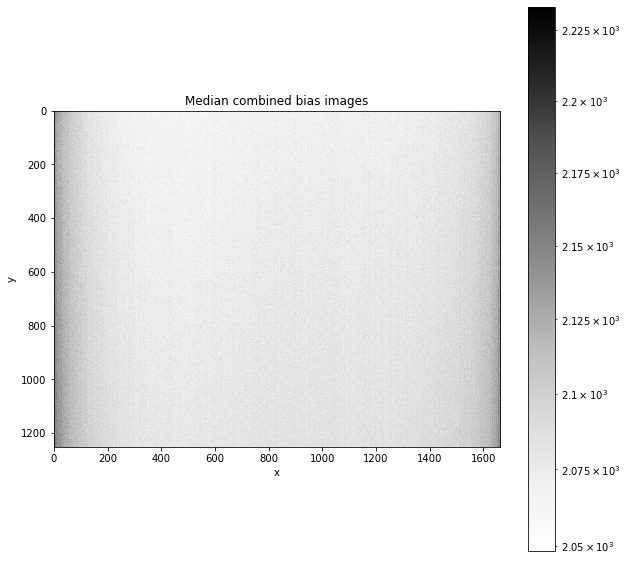

In [7]:
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(bias_median, cmap = 'Greys', norm = LogNorm())
plt.title('Median combined bias images')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

***Figure 1.*** Median combined bias image. The image looks relatively uniform, with a little random noise. The left and right edges of the bias are slightly brighter than the rest of the image.

Before we save the image, we need to update the header of the combined image.

In [10]:
bias_median.meta.update(EXPTIME = 0)                              # add the exposure time
bias_median.meta.update(TELESCOP = biases[0].header['TELESCOP'])  # add the telescope used
bias_median.meta.update(OBJECT = 'Bias_Median')                   # add the object name to identify this image as the median combined bias image
print(bias_median.meta)

OrderedDict([('NCOMBINE', 100), ('EXPTIME', 0), ('TELESCOP', 'C11'), ('OBJECT', 'Bias_Median')])


In [9]:
bias_median.write("bias_median.fits")     # writes the median combined bias image to a FITS file called 'bias_median.fits'

OSError: File 'bias_median.fits' already exists.

In [11]:
# delete the bias data from the jupyter notebook to clear the memory
del(biases)
collected = gc.collect()
print('Check garbage collection', collected)

Check garbage collection 3216
